# Data Exploration for League of Legends Bayesian Network

This notebook explores the match data, checks data quality, and validates discretization.


In [2]:
# Imports
import sys
sys.path.insert(0, '..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from src import config, preprocessing, discretization, variables

# Configure plotting
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

%matplotlib inline
%load_ext autoreload
%autoreload 2


## 1. Load Raw Data

Let's start by loading a sample of the raw match data.


In [3]:
# Load a sample of raw data for exploration (use 5000 samples for speed)
sample_size = 5000
raw_data = preprocessing.load_raw_match_data(sample_size=sample_size)

print(f"Loaded {len(raw_data)} matches")
print(f"Columns: {len(raw_data.columns)}")
print(f"\nFirst few columns: {list(raw_data.columns)[:20]}")


INFO:src.preprocessing:Loading match data from /home/kano/Documents/bdsproject/notebooks/../data/matchData.csv
INFO:src.preprocessing:Loaded 5000 matches


Loaded 5000 matches
Columns: 1770

First few columns: ['dataVersion', 'matchId', 'endOfGameResult', 'gameCreation', 'gameDuration', 'gameEndTimestamp', 'gameId', 'gameMode', 'gameName', 'gameType', 'gameVersion', 'mapId', 'participant0PlayerScore0', 'participant0PlayerScore1', 'participant0PlayerScore10', 'participant0PlayerScore11', 'participant0PlayerScore2', 'participant0PlayerScore3', 'participant0PlayerScore4', 'participant0PlayerScore5']


## 2. Extract Team Features


In [4]:
# Extract team-level features
features = preprocessing.extract_team_features(raw_data)

print(f"Extracted {len(features)} matches with {len(features.columns)} features")
print(f"\nFeatures: {list(features.columns)}")
print(f"\nFirst few rows:")
features.head()


INFO:src.preprocessing:Extracting features from team0 perspective
INFO:src.preprocessing:Extracted features for 4882 matches


Extracted 4882 matches with 15 features

Features: ['matchId', 'gameDuration', 'FB', 'FT', 'Kills10', 'Gold10', 'Herald', 'Kills20', 'Gold20', 'Drakes', 'Soul', 'Baron', 'Inhibs', 'Towers', 'Win']

First few rows:


,matchId,gameDuration,FB,FT,Kills10,Gold10,Herald,Kills20,Gold20,Drakes,Soul,Baron,Inhibs,Towers,Win
0,NA1_5336703338,1867,0,0,5.243428,298.028492,1,16.528642,5243.756891,3,None,1,1,6,1
1,NA1_5336551601,1924,0,0,2.973471,-82.958581,1,8.801282,3337.297828,4,None,1,1,4,1
2,NA1_5334823877,2305,0,0,-4.954623,388.613123,0,-14.690025,-2769.391778,0,None,1,-6,-8,0
3,NA1_5350241781,2831,0,0,1.796060,913.817914,1,10.599694,5893.756727,2,None,3,2,4,1
4,NA1_5345879821,1613,0,0,-6.968307,-140.492025,1,-20.121997,-3544.891412,0,None,0,-2,-7,0


## 3. Basic Statistics


In [5]:
# Summary statistics
features.describe()


,gameDuration,FB,FT,Kills10,Gold10,Herald,Kills20,Gold20,Drakes,Baron,Inhibs,Towers,Win
count,4882.000000,4882.0,4882.0,4882.000000,4882.000000,4882.000000,4882.000000,4882.000000,4882.000000,4882.000000,4882.000000,4882.000000,4882.000000
mean,1719.497542,0.0,0.0,-0.000700,5.028527,0.606104,0.111809,852.732354,1.787997,0.369111,0.050594,0.115322,0.502868
std,381.392667,0.0,0.0,4.279515,599.929276,0.488662,13.679824,3966.281329,1.307440,0.574123,1.924540,6.230893,0.500043
min,910.000000,0.0,0.0,-15.414311,-1944.760404,0.000000,-41.909011,-9852.450156,0.000000,0.000000,-8.000000,-13.000000,0.000000
25%,1500.000000,0.0,0.0,-3.354643,-394.929259,0.000000,-11.113074,-2272.291790,1.000000,0.000000,-1.000000,-6.000000,0.000000
50%,1710.000000,0.0,0.0,-0.000833,11.175895,1.000000,0.188096,904.853924,2.000000,0.000000,0.000000,0.000000,1.000000
75%,1933.750000,0.0,0.0,3.327058,406.747940,1.000000,11.277367,3990.800676,3.000000,1.000000,1.000000,6.000000,1.000000
max,3791.000000,0.0,0.0,13.205463,2355.742624,1.000000,41.642755,12203.279408,5.000000,3.000000,8.000000,13.000000,1.000000


In [6]:
# Check for missing values
print("Missing values:")
print(features.isnull().sum())
print(f"\nTotal missing: {features.isnull().sum().sum()}")


Missing values:
matchId         0
gameDuration    0
FB              0
FT              0
Kills10         0
Gold10          0
Herald          0
Kills20         0
Gold20          0
Drakes          0
Soul            0
Baron           0
Inhibs          0
Towers          0
Win             0
dtype: int64

Total missing: 0


## 4. Discretization


In [7]:
# Apply discretization
features_clean = features.drop(columns=['matchId', 'gameDuration'], errors='ignore')
discretized = discretization.discretize_all_variables(features_clean.copy())

print("Discretized data:")
discretized.head(10)


Discretized data:


,FB,FT,Kills10,Gold10,Herald,Kills20,Gold20,Drakes,Soul,Baron,Inhibs,Towers,Win
0,0,0,ahead,neutral,1,ahead,high,3,None,1,>=1,>=2,1
1,0,0,ahead,neutral,1,ahead,high,4+,None,1,>=1,>=2,1
2,0,0,behind,neutral,0,behind,neutral,0,None,1,<=-1,<=-2,0
3,0,0,even,neutral,1,ahead,high,2,None,2+,>=1,>=2,1
4,0,0,behind,neutral,1,behind,low,0,None,0,<=-1,<=-2,0
5,0,0,behind,neutral,0,behind,low,0,None,0,<=-1,<=-2,0
6,0,0,even,neutral,1,even,neutral,0,None,0,<=-1,<=-2,0
7,0,0,ahead,neutral,1,ahead,high,2,None,0,0,>=2,1
8,0,0,ahead,neutral,1,ahead,high,3,None,0,>=1,>=2,1
9,0,0,ahead,neutral,0,ahead,high,2,None,1,>=1,>=2,1


In [8]:
# Get discretization summary
summary = discretization.get_discretization_summary(discretized)
print("\nDiscretization Summary:")
print(summary.to_string(index=False))



Discretization Summary:
Variable    Value  Count Percentage
  Gold10  neutral   4423     90.60%
  Gold10     high    230      4.71%
  Gold10      low    229      4.69%
 Kills10     even   1801     36.89%
 Kills10    ahead   1541     31.56%
 Kills10   behind   1540     31.54%
  Herald        1   2959     60.61%
  Herald        0   1923     39.39%
  Gold20  neutral   2316     47.44%
  Gold20     high   1618     33.14%
  Gold20      low    948     19.42%
 Kills20    ahead   1879     38.49%
 Kills20   behind   1850     37.89%
 Kills20     even   1153     23.62%
  Drakes        2   1240     25.40%
  Drakes        1   1177     24.11%
  Drakes        0    980     20.07%
  Drakes        3    933     19.11%
  Drakes       4+    552     11.31%
    Soul     None   4449     91.13%
    Soul    Cloud    121      2.48%
    Soul    Ocean    119      2.44%
    Soul Mountain    106      2.17%
    Soul Infernal     87      1.78%
   Baron        0   3298     67.55%
   Baron        1   1384     28.35%
   

## 5. Variable Distributions


INFO:src.visualize:Creating variable distribution plot for Sample Data


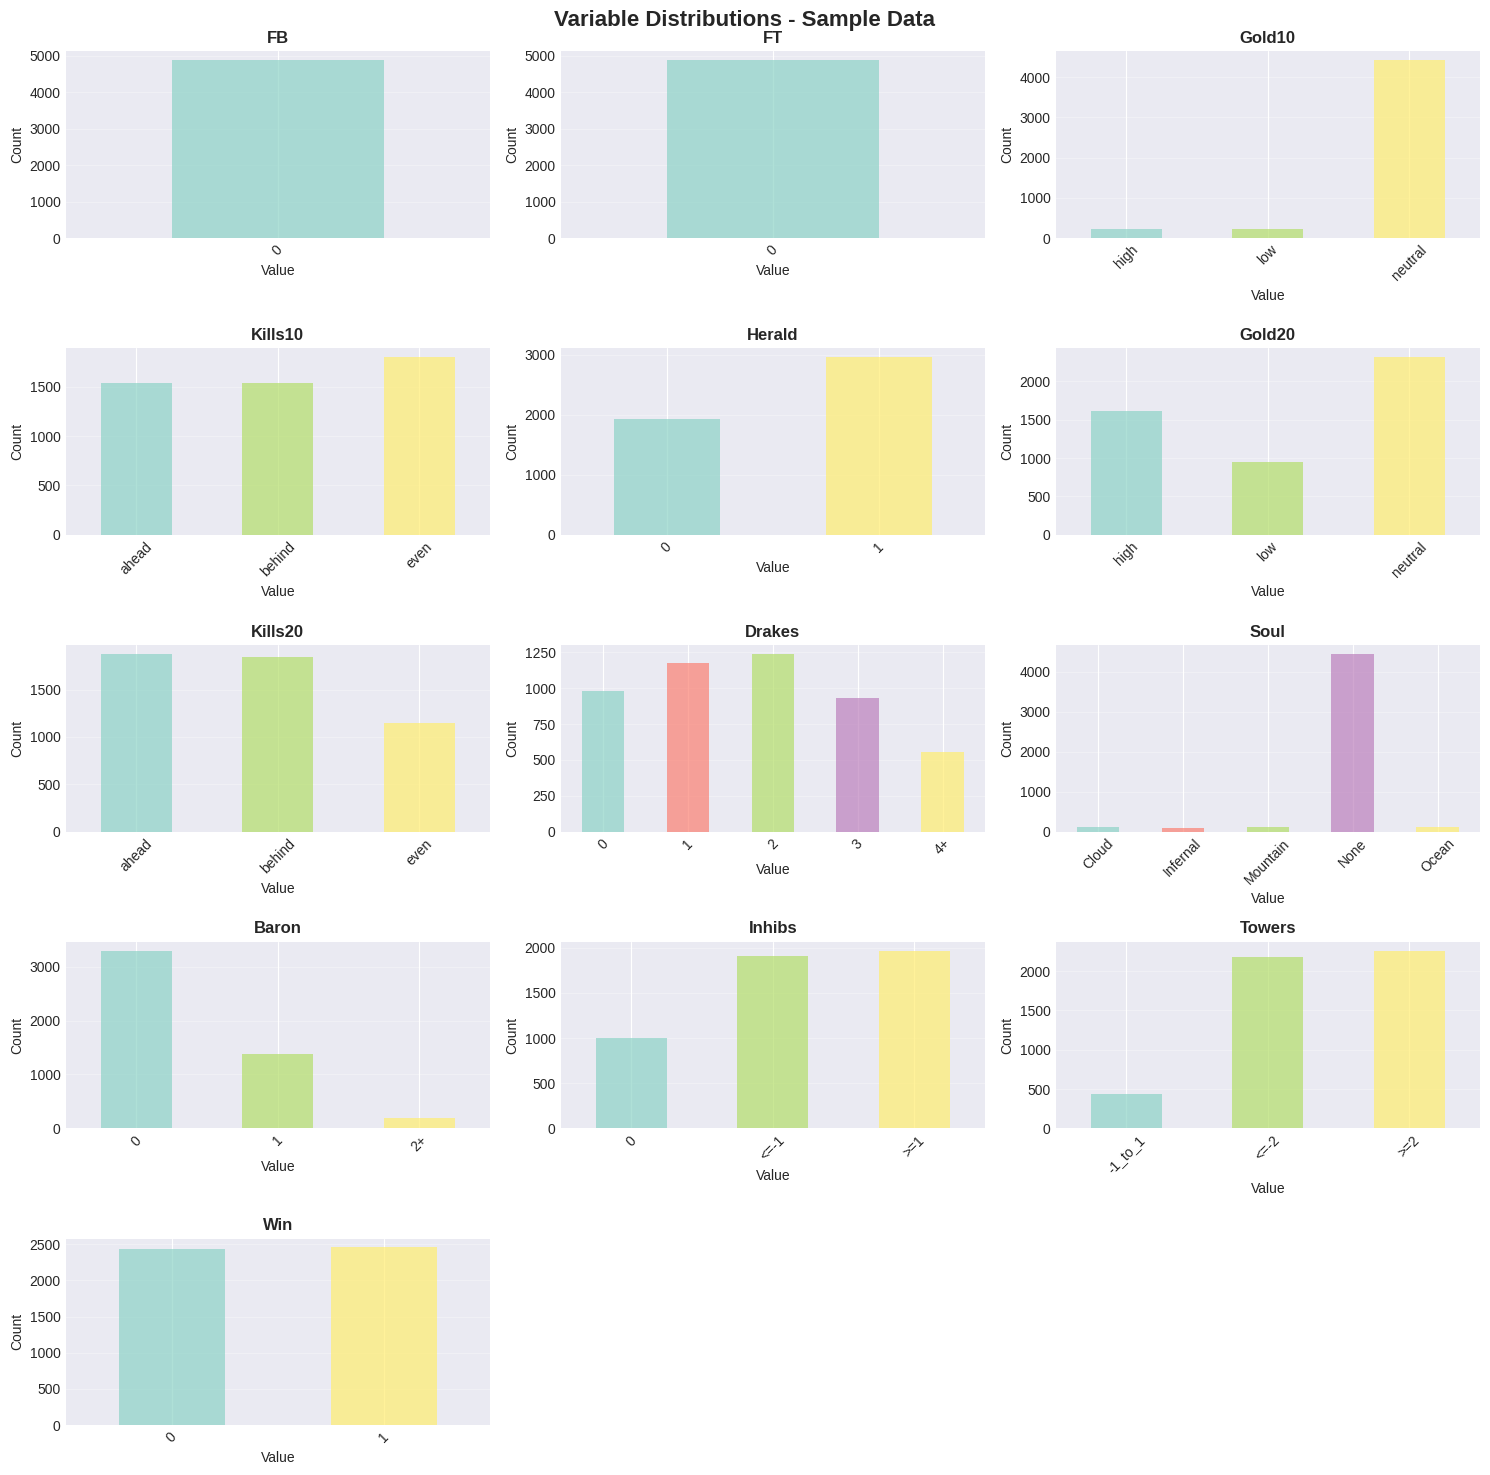

In [9]:
# Plot distributions
from src.visualize import plot_variable_distributions

fig = plot_variable_distributions(discretized, "Sample Data")
plt.show()


## 6. Win Rate Analysis


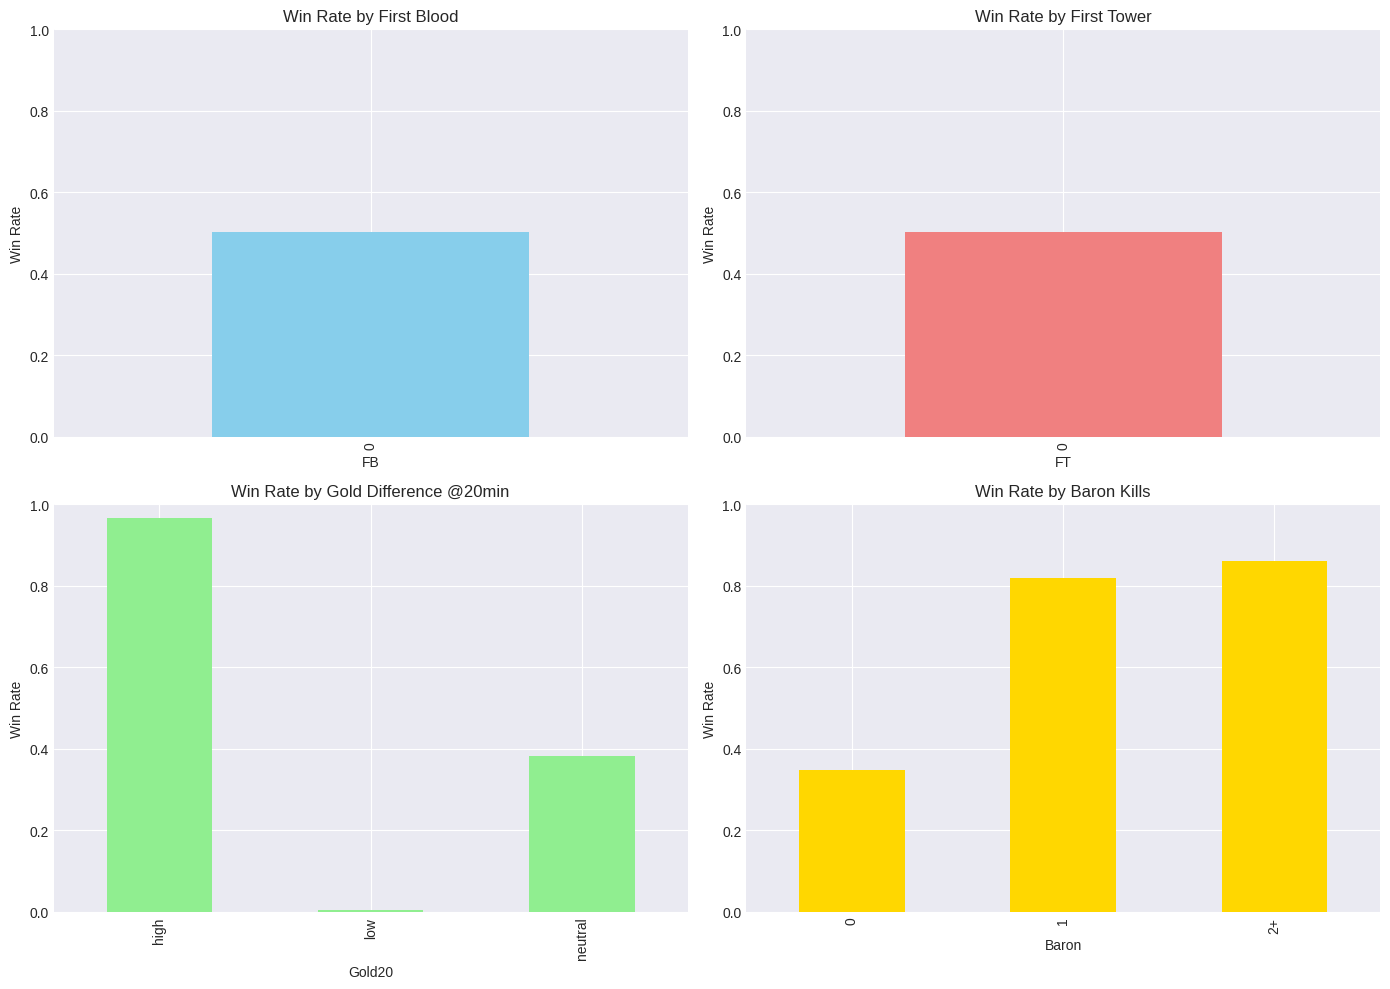

In [10]:
# Win rate by different factors
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Win rate by First Blood
fb_win = discretized.groupby('FB')['Win'].apply(lambda x: (x == '1').mean())
fb_win.plot(kind='bar', ax=axes[0, 0], color='skyblue')
axes[0, 0].set_title('Win Rate by First Blood')
axes[0, 0].set_ylabel('Win Rate')
axes[0, 0].set_ylim([0, 1])

# Win rate by First Tower
ft_win = discretized.groupby('FT')['Win'].apply(lambda x: (x == '1').mean())
ft_win.plot(kind='bar', ax=axes[0, 1], color='lightcoral')
axes[0, 1].set_title('Win Rate by First Tower')
axes[0, 1].set_ylabel('Win Rate')
axes[0, 1].set_ylim([0, 1])

# Win rate by Gold20
gold_win = discretized.groupby('Gold20')['Win'].apply(lambda x: (x == '1').mean())
gold_win.plot(kind='bar', ax=axes[1, 0], color='lightgreen')
axes[1, 0].set_title('Win Rate by Gold Difference @20min')
axes[1, 0].set_ylabel('Win Rate')
axes[1, 0].set_ylim([0, 1])

# Win rate by Baron
baron_win = discretized.groupby('Baron')['Win'].apply(lambda x: (x == '1').mean())
baron_win.plot(kind='bar', ax=axes[1, 1], color='gold')
axes[1, 1].set_title('Win Rate by Baron Kills')
axes[1, 1].set_ylabel('Win Rate')
axes[1, 1].set_ylim([0, 1])

plt.tight_layout()
plt.show()


## 7. Correlation Analysis


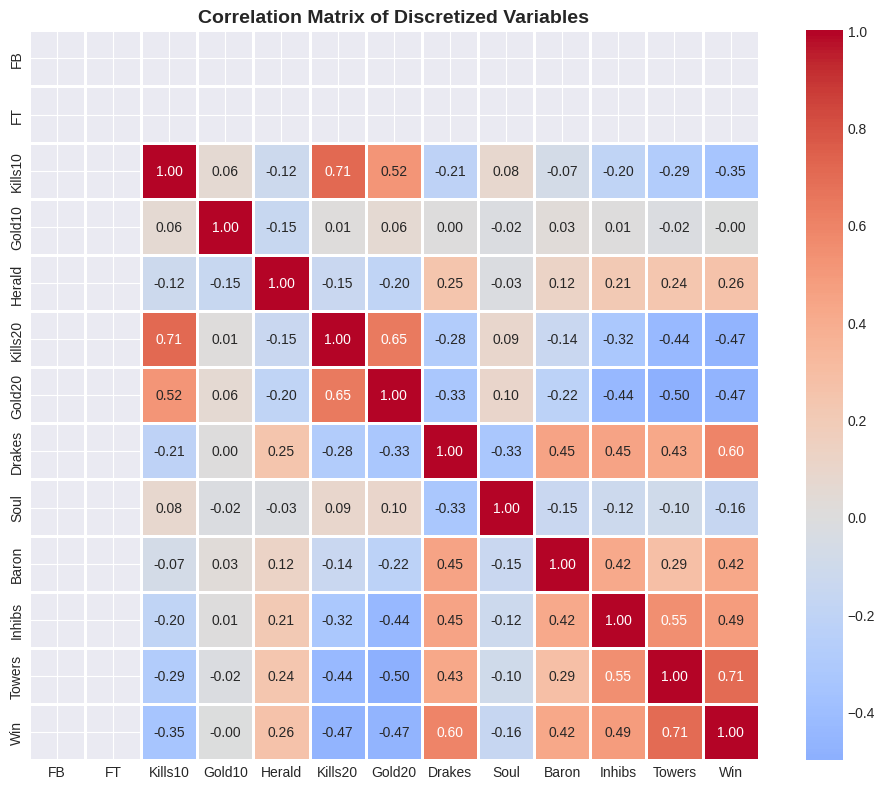

In [11]:
# Encode categorical variables as integers for correlation
from sklearn.preprocessing import LabelEncoder

encoded_data = discretized.copy()
for col in encoded_data.columns:
    le = LabelEncoder()
    encoded_data[col] = le.fit_transform(encoded_data[col].astype(str))

# Compute correlation matrix
corr = encoded_data.corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', center=0, 
            square=True, linewidths=1)
plt.title('Correlation Matrix of Discretized Variables', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


## 8. Rank Distribution


INFO:src.preprocessing:Loading match IDs from /home/kano/Documents/bdsproject/notebooks/../data/match_ids.csv
INFO:src.preprocessing:Assigning rank buckets
INFO:src.preprocessing:Rank distribution:
rank_bucket
Master      1859
Diamond     1011
Platinum     911
Elite        337
Name: count, dtype: int64


Rank distribution:
rank_bucket
Master      1859
Diamond     1011
Platinum     911
Elite        337
Name: count, dtype: int64


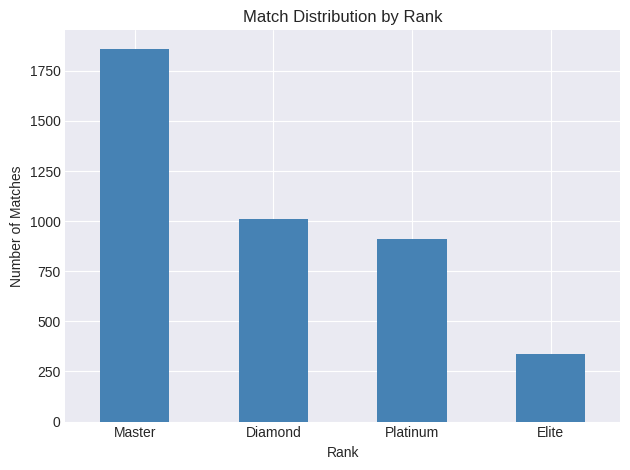

In [12]:
# Load match IDs and assign rank buckets
match_ids = preprocessing.load_match_ids()
features_with_rank = preprocessing.assign_rank_bucket(features, match_ids)

print("Rank distribution:")
print(features_with_rank['rank_bucket'].value_counts())

# Plot
features_with_rank['rank_bucket'].value_counts().plot(kind='bar', color='steelblue')
plt.title('Match Distribution by Rank')
plt.xlabel('Rank')
plt.ylabel('Number of Matches')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


We see
- No missing values
- Mostly balanced class distribution (Win should be ~50%)
- Clear relationships between objectives and outcomes
- Sufficient samples across rank tiers

